In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

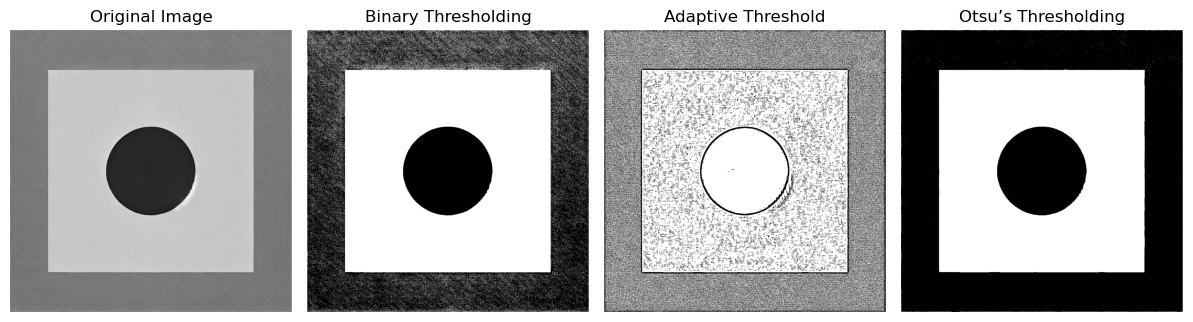

In [80]:
# Sea bottom image
image = cv2.imread('./otsu_gen.png', cv2.IMREAD_GRAYSCALE)

_, binary_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                             cv2.THRESH_BINARY, 11, 2)
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles = ['Original Image', 'Binary Thresholding', 'Adaptive Threshold', 'Otsu’s Thresholding']
images = [image, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

On visualizing it has a bimodal histogram and many pixels around the middle gray values. Otsu's is the best here unlike binary we need manually tune the threshold especially since there are more of pixel values near the threshold and Adaptive thresold only considers the local neighbourhood

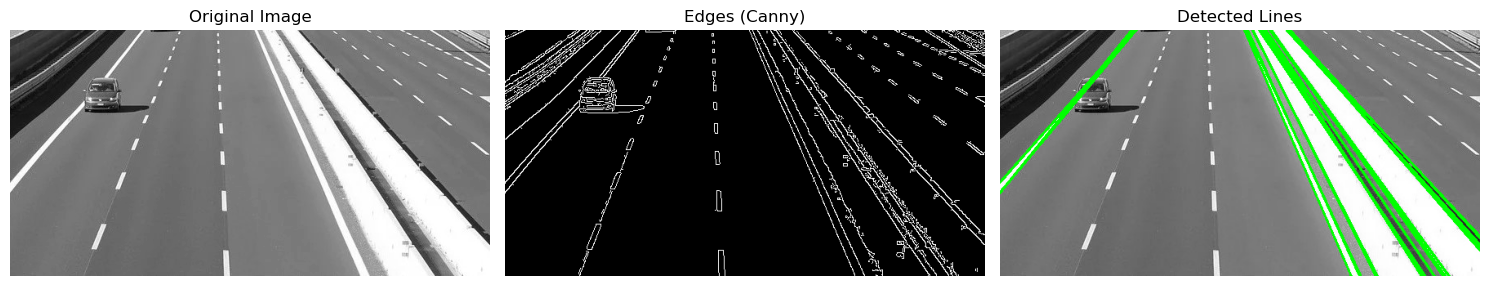

In [70]:
def detectLinesHough(image_path, rho=1, theta=np.pi/180, threshold=100):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    
    lines = cv2.HoughLines(edges, rho, theta, threshold)
    
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(color_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return image, edges, color_image

image_path = 'hough-transform.png'  
original, edges, result = detectLinesHough(image_path, rho=1, theta=np.pi/360, threshold=150)

titles = ['Original Image', 'Edges (Canny)', 'Detected Lines']
images = [original, edges, result]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i] if i == 2 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Reduced rho increases precision of lines. Increasing threshold removes less prominent lines. Smaller theta values increases the accurate detection of angled lines

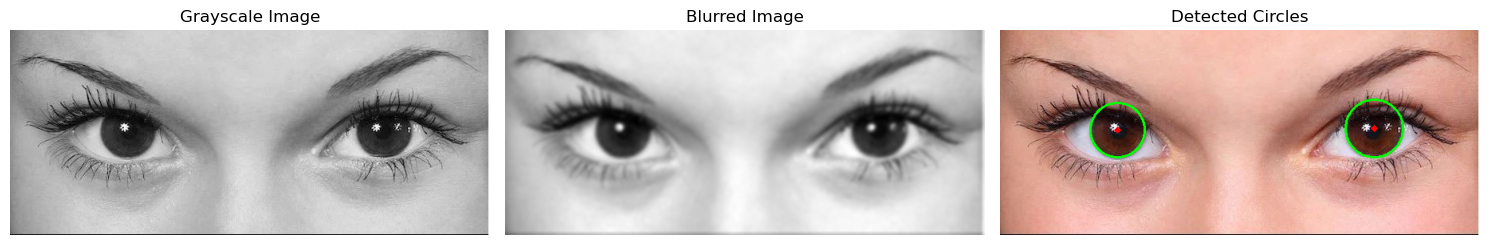

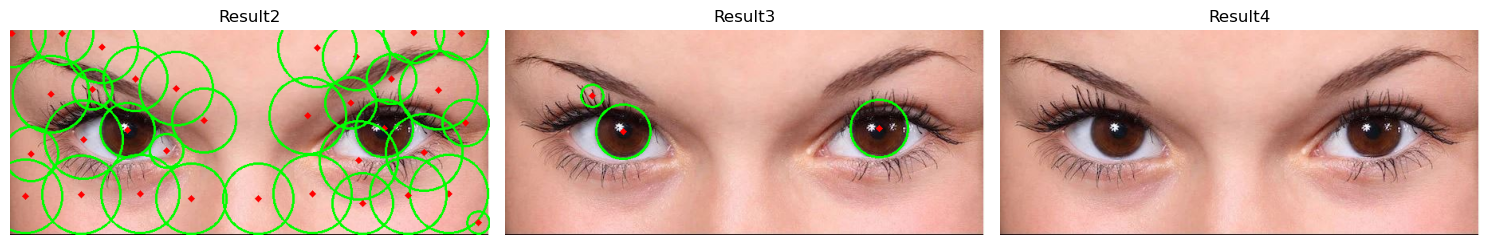

In [81]:
def detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=30, minRadius=0, maxRadius=0):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp, minDist, 
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    
    output_image = image.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles)) 
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]              
            cv2.circle(output_image, center, radius, (0, 255, 0), 2)  
            cv2.circle(output_image, center, 2, (0, 0, 255), 3)       

    return gray_image, blurred_image, output_image

image_path = 'eyes.jpeg' 
gray, blurred, result = detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=30, minRadius=10, maxRadius=50)

result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
titles = ['Grayscale Image', 'Blurred Image', 'Detected Circles']
images = [gray, blurred, result]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i] if i == 2 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Experimentaion
_, _, result2 = detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=5, minRadius=10, maxRadius=50)
_, _, result3 = detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=30, minRadius=5, maxRadius=50)
_, _, result4 = detectCirclesHough(image_path, dp=1.2, minDist=50, param1=100, param2=30, minRadius=5, maxRadius=10)

result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)
result3 = cv2.cvtColor(result3, cv2.COLOR_BGR2RGB)
result4 = cv2.cvtColor(result4, cv2.COLOR_BGR2RGB)
titles = ['Result2', 'Result3', 'Result4']
images = [result2, result3, result4]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

min and maxRadius are specific to the image. It restricts the detected circle to that particular size. As param2 increases no of circles also increases.

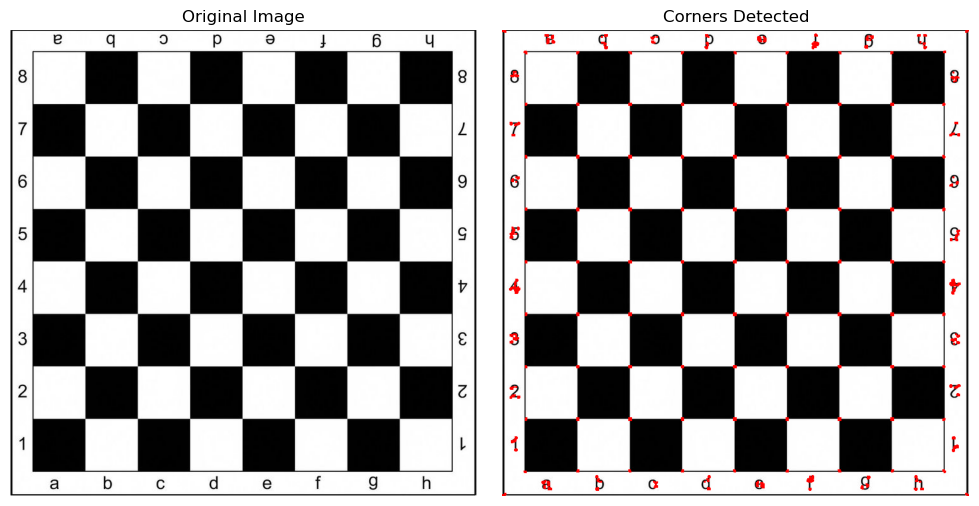

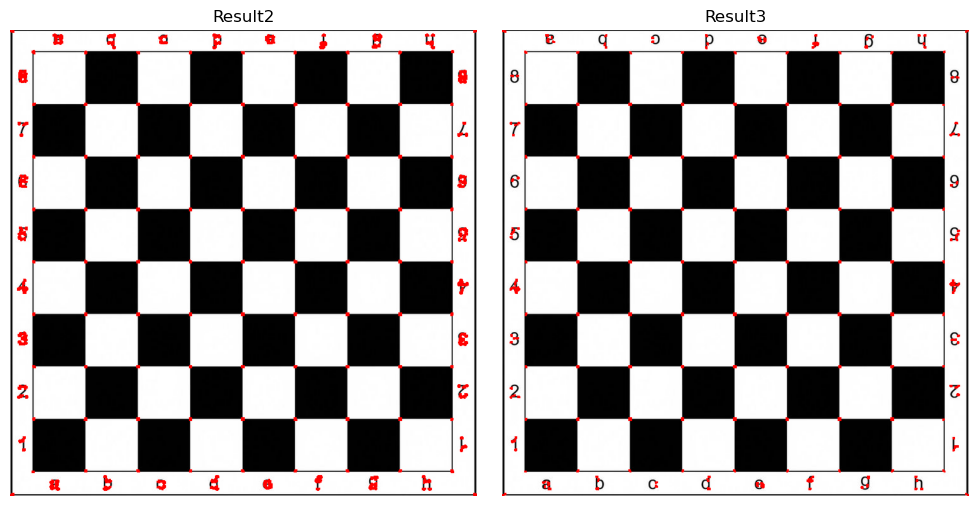

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def harrisCornerDetection(image_path, blockSize=2, ksize=3, k=0.04, threshold=0.01):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    gray_image = np.float32(gray_image)
    
    harris_response = cv2.cornerHarris(gray_image, blockSize, ksize, k)
    
    dilated_response = cv2.dilate(harris_response, None)
    
    thresholded_image = image.copy()
    threshold_value = threshold * dilated_response.max()
    thresholded_image[dilated_response > threshold_value] = [0, 0, 255]  # Mark corners in red
    
    return image, thresholded_image

image_path = 'chessboard.jpeg' 
original, processed = harrisCornerDetection(image_path, blockSize=2, ksize=3, k=0.04, threshold=0.01)

titles = ['Original Image', 'Corners Detected']
images = [original, processed]

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) 
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

_, res2 = harrisCornerDetection(image_path, blockSize=2, ksize=3, k=0.01, threshold=0.01)
_, res3 = harrisCornerDetection(image_path, blockSize=2, ksize=3, k=0.08, threshold=0.01)
titles = ['Result2', 'Result3']
images = [res2, res3]

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)) 
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


As k decreases more corners are detected especially around the digits but on increasing k stronger corners are detected. 

**Task 5**

The definition of the parameter space and the computational complexity of the Hough Transform for line and circle detection are different. The parameter space for line detection is two-dimensional and represents the angle $\theta$ of the line with respect to the x-axis and its distance from the origin. The process is reasonably efficient because each point in the image casts a vote for lines that pass through it.

The parameter space for circle detection is three-dimensional and consists of the radius (r) and the circle's centre coordinates (x, y). Higher computational complexity results from each edge pixel voting for every circle to which it may belong, particularly when variable radius detection is used.

Circle detection needs more memory and processing to account for the extra radius dimension, whereas line detection is quicker because its parameter space is simpler.